Бонусный материал: мы уже умеем подключать нейросеть к среде и использовать для обучения Q-функции, но можно немного улучшить написанный ранее код, объединив модели для каждого действия в одну.

In [1]:
import gym
import torch

from collections import deque
import random

from torch.autograd import Variable

In [2]:
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(n_state, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_action)
                )

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        """
        Update the weights of the DQN given a training sample
        @param s: state
        @param y: target value
        """
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, s):
        """
        Compute the Q values of the state for all actions using the learning model
        @param s: input state
        @return: Q values of the state for all actions
        """
        with torch.no_grad():
            return self.model(torch.Tensor(s))


    def replay(self, memory, replay_size, gamma):
        """
        Experience replay
        @param memory: a list of experience
        @param replay_size: the number of samples we use to update the model each time
        @param gamma: the discount factor
        """
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)
            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                td_targets.append(q_values)

            self.update(states, td_targets)

In [3]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()
    return policy_function

In [4]:
def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    """
    Deep Q-Learning using DQN, with experience replay
    @param env: Gym environment
    @param estimator: DQN object
    @param replay_size: the number of samples we use to update the model each time
    @param n_episode: number of episodes
    @param gamma: the discount factor
    @param epsilon: parameter for epsilon_greedy
    @param epsilon_decay: epsilon decreasing factor
    """
    for episode in range(n_episode):
        policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action)
        state = env.reset()
        is_done = False

        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            total_reward_episode[episode] += reward

            modified_reward = next_state[0] + 0.5
            if next_state[0] >= 0.5:
                modified_reward += 100
            elif next_state[0] >= 0.25:
                modified_reward += 20
            elif next_state[0] >= 0.1:
                modified_reward += 10
            elif next_state[0] >= 0:
                modified_reward += 5

            memory.append((state, action, next_state, modified_reward, is_done))

            if is_done:
                break

            estimator.replay(memory, replay_size, gamma)
            state = next_state
        #if episode % 20 == 0:
        print('Episode: {}, total reward: {}, epsilon: {}'.format(episode, total_reward_episode[episode], epsilon))

        epsilon = max(epsilon * epsilon_decay, 0.01)

In [5]:
env = gym.envs.make("MountainCar-v0")

In [6]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 50
lr = 0.001
dqn = DQN(n_state, n_action, n_hidden, lr)


In [ ]:
memory = deque(maxlen=10000)

n_episode = 1100
replay_size = 20
total_reward_episode = [0] * n_episode

q_learning(env, dqn, n_episode, replay_size, gamma=.9, epsilon=.3)

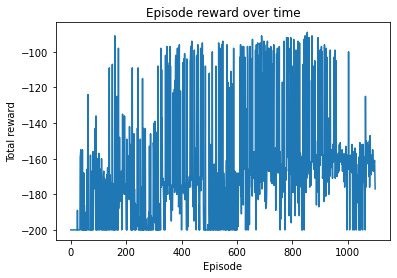

In [8]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()